In [16]:
from collections import Counter
import random

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import normalizers
from tokenizers.normalizers import NFD, StripAccents, Lowercase
from tokenizers.pre_tokenizers import Whitespace

from datasets import load_dataset

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [17]:
dataset = load_dataset("dair-ai/emotion")

In [18]:
train_data = dataset['train']
test_data = dataset['test']
validation_data = dataset['validation']

In [19]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.enable_padding()
trainer = BpeTrainer(special_tokens=[
	"[UNK]" , "[PAD]"
])

normalizer = normalizers.Sequence([NFD(), StripAccents(), Lowercase()])
tokenizer.normalizer = normalizer

pre_tokenizer = Whitespace()
tokenizer.pre_tokenizer = pre_tokenizer

tokenizer.train_from_iterator(train_data['text'], trainer)

padding_idx = tokenizer.token_to_id("[PAD]")

In [20]:
def tokenization(example):
	output = tokenizer.encode(example['text'])
	return {
		"ids": output.ids,
		"type_ids": output.type_ids,
		"attention_mask": output.attention_mask
	}

train_data_tokenized = train_data.map(tokenization)
train_data_tokenized.set_format(type="torch", columns=["ids", "type_ids", "attention_mask", "label"])

validation_data_tokenized = validation_data.map(tokenization)
validation_data_tokenized.set_format(type="torch", columns=["ids", "type_ids", "attention_mask", "label"])

In [21]:
print("Train label distribution:")
train_label_counts = Counter(train_data['label'])
for label, count in sorted(train_label_counts.items()):
    print(f"  Label {label}: {count} samples")

print("\nTest label distribution:")
test_label_counts = Counter(test_data['label'])
for label, count in sorted(test_label_counts.items()):
    print(f"  Label {label}: {count} samples")

Train label distribution:
  Label 0: 4666 samples
  Label 1: 5362 samples
  Label 2: 1304 samples
  Label 3: 2159 samples
  Label 4: 1937 samples
  Label 5: 572 samples

Test label distribution:
  Label 0: 581 samples
  Label 1: 695 samples
  Label 2: 159 samples
  Label 3: 275 samples
  Label 4: 224 samples
  Label 5: 66 samples


In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size
        
        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.RNN(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)
        if self.rnn.bidirectional:
            hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            hidden = h_n[-1]
        
        hidden = self.dropout(hidden)
        logits = self.h2o(hidden)
        return logits

In [25]:
input_size = tokenizer.get_vocab_size()
emb_size = 256
hidden_size = 128
output_size = len(set(train_data['label']))

model = RNN(input_size, emb_size, hidden_size, output_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

label_counts = Counter(train_data['label'])
total = sum(label_counts.values())
class_weights = torch.tensor([total / (len(label_counts) * label_counts[i]) for i in range(len(label_counts))])
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
def collate_fn(batch):
	ids = [torch.as_tensor(x["ids"], dtype=torch.long) for x in batch]
	attn = [torch.as_tensor(x["attention_mask"], dtype=torch.long) for x in batch]
	labels = torch.as_tensor([x["label"] for x in batch], dtype=torch.long)
	
	ids = torch.nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=padding_idx)
	attn = torch.nn.utils.rnn.pad_sequence(attn, batch_first=True, padding_value=0)

	lengths = attn.sum(dim=1)
	return {
		"input_ids": ids,
		"attention_mask": attn,
		"labels": labels,
		"lengths": lengths,
	}

In [27]:
train_data_loader = DataLoader(train_data_tokenized, batch_size=32, collate_fn=collate_fn, shuffle=True)
validation_data_loader = DataLoader(validation_data_tokenized, batch_size=32, collate_fn=collate_fn, shuffle=False)

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)

    for batch, data in enumerate(dataloader):
        X = data['input_ids']
        y = data['labels']
        lengths = data['lengths']
        
        preds = model(X, lengths)
        loss = loss_fn(preds, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_loss = total_loss / num_batches
    return avg_loss

def eval_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    total_correct, total_examples = 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for data in dataloader:
            X = data['input_ids']
            y = data['labels']
            lengths = data['lengths']
            
            preds = model(X, lengths)
            pred_labels = torch.argmax(preds, dim=1)
            loss = loss_fn(preds, y)
            total_loss += loss.item()

            total_examples += X.size()[0]
            total_correct += (pred_labels == y).sum().item()
    
    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_examples * 100
    return avg_loss, accuracy


In [29]:
train_losses = []
validation_losses = []
validation_accuracies = []
for epoch in range(5):
    train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    validation_loss, validation_accuracy = eval_loop(validation_data_loader, model, loss_fn)
    print(f"Epoch: {epoch + 1}, Training Loss:{train_loss:.4f}, Validation Loss:{validation_loss:.4f}, Validation Accuracy:{validation_accuracy:.4f}")
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

Epoch: 1, Training Loss:1.7707, Validation Loss:1.7120, Validation Accuracy:28.1500
Epoch: 2, Training Loss:1.3946, Validation Loss:1.3862, Validation Accuracy:37.2500
Epoch: 3, Training Loss:0.9593, Validation Loss:0.7356, Validation Accuracy:71.4000
Epoch: 4, Training Loss:0.6913, Validation Loss:0.6577, Validation Accuracy:81.7500
Epoch: 5, Training Loss:0.5507, Validation Loss:0.5932, Validation Accuracy:83.2500


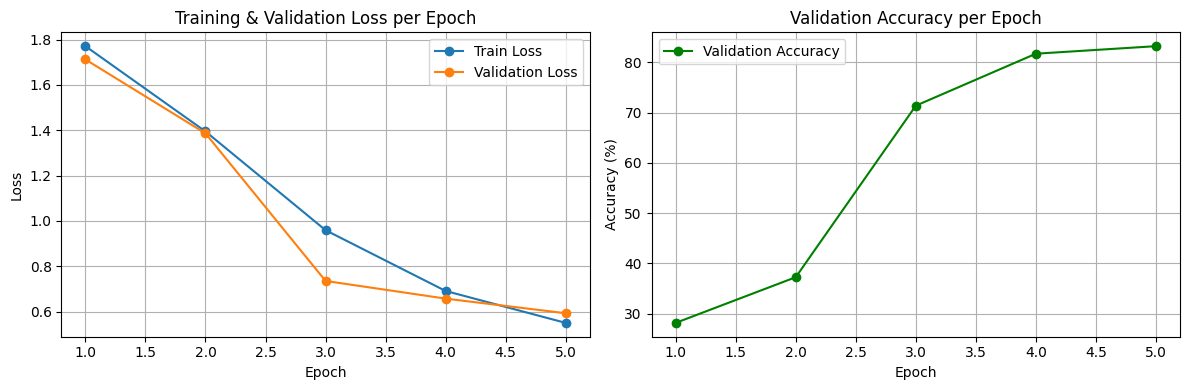

In [30]:
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, train_losses, marker='o', label='Train Loss')
axes[0].plot(epochs, validation_losses, marker='o', label='Validation Loss')
axes[0].set_title("Training & Validation Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(epochs, validation_accuracies, marker='o', color='green', label='Validation Accuracy')
axes[1].set_title("Validation Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [31]:
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def predict(text, model, tokenizer):
    model.eval()
    
    encoding = tokenizer.encode(text)
    ids = torch.tensor([encoding.ids], dtype=torch.long)
    lengths = torch.tensor([len(encoding.ids)], dtype=torch.long)

    with torch.no_grad():
        logits = model(ids, lengths)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        pred_label = torch.argmax(probs).item()

    print(f"\nInput text: {text}")
    print(f"Predicted Emotion: {label_names[pred_label].upper()} (class {pred_label})")

In [32]:
for _ in range(5):
    sample = random.choice(test_data)
    text, true_label = sample["text"], sample["label"]
    print(f"\nActual label: {label_names[true_label].upper()} (class {true_label})")
    predict(text, model, tokenizer)


Actual label: ANGER (class 3)

Input text: i feel like i fucked up big time but i have to protect a and myself
Predicted Emotion: ANGER (class 3)

Actual label: LOVE (class 2)

Input text: i have found myself overwhelmed with jealousy and self contempt and i have found myself feeling this towards the lives of my sweet friends and acquaintances as portrayed on social media
Predicted Emotion: LOVE (class 2)

Actual label: SADNESS (class 0)

Input text: i feel so much boring with my straight hair for all over years haha
Predicted Emotion: SADNESS (class 0)

Actual label: FEAR (class 4)

Input text: i feel alarmed
Predicted Emotion: FEAR (class 4)

Actual label: LOVE (class 2)

Input text: i feel more loyal to micah
Predicted Emotion: LOVE (class 2)
